In [1]:
import numpy as np
import os
import json
import pandas as pd
import gensim.downloader
from sklearn.manifold import MDS

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects
import seaborn as sns

## Data Gatherings

In [2]:
trial_df = pd.read_csv("export-data/SREnextthirty-final/data/SRETrial.csv")
node_df = pd.read_csv("export-data/SREnextthirty-final/data/SRENode.csv")
node_degrees = node_df[["id", "degree"]]

In [3]:
trial_df_compact = trial_df.query("failed==False")[["id", "origin_id", "network_id", "previous_sample", "obtained_response", "time_taken"]]
trial_df_compact = trial_df_compact\
    .rename(columns = {"id": "trial_id"})\
    .set_index("trial_id")
trial_df_compact["previous_sample"] = trial_df_compact["previous_sample"].map(json.loads)
trial_df_compact["provided_prompt"] = trial_df_compact["previous_sample"].map(lambda x: x["obtained_response"])
trial_df_compact["node_mode"] = trial_df_compact["previous_sample"].map(lambda x: x["current_mode"])
trial_df_compact = trial_df_compact\
                       .drop(columns=["previous_sample"])\
                       .iloc[:, [0, 1, 5, 4, 2, 3]].dropna()
trial_df_compact = trial_df_compact.merge(node_degrees, left_on="origin_id", right_on="id").drop(columns="id")
trial_df_compact

,origin_id,network_id,node_mode,provided_prompt,obtained_response,time_taken,degree
0,2,2,s,authoritative,You need to finish this by Wednesday.,27.202,0
1,1,1,c,That sounds like a great day.,excited,17.887,0
2,39,39,c,I went to see Mary Poppins in London and I was...,reminiscent,26.857,0
3,94,1,s,excited,"Wow, what an amazing thing to happen.",83.199,1
4,28,28,c,I started using this tool a month ago and I am...,persuasive,6.740,0
...,...,...,...,...,...,...,...
2892,3009,1,c,I just got a new promotion!,happy,15.108,94
2893,3008,49,c,I am full of joy today.,delighted,26.323,29
2894,3012,2,c,Everything is silent as she has left us for good.,sad,20.803,101
2895,3011,7,s,joyful,The sun has come out and the ice cream van has...,31.157,29


In [13]:
list(trial_df_compact.query("network_id > 2 and degree==29 and node_mode=='s'")["obtained_response"])

['I appreciate being able to eat daily.',
 'I am so pleased for you, that`s wonderful news.',
 'What fascinating mysteries lie ahead?',
 'I know that I am so good looking.',
 'I just want to go home and cry.',
 'I really can`t believe you just said that.',
 'I have always been there for both of my children.',
 'I don`t know why, but I don`t trust him!',
 'I am unsure about what is going to happen next.',
 'I have won a large sum of money on the lottery.',
 'If you need anything, please ask.',
 'I really love your outfit, it looks amazing, you wear it so well!',
 'I was relaxing listening to my music with a nice drink and some snacks.',
 'The rain has not stopped for the last fortnight, if this continues, the crops in the fields will be ruined!',
 'She was overjoyed at the birth of her first grandchild.',
 'I`d be happy to help you with that.',
 'That`s really great, I`m so pleased.',
 'I can`t wait to see his face when he gets the money.',
 'I have no idea how this happened.',
 'Being 

===================

In [11]:
practice_trials, chain_trials = trial_df_compact.query("network_id <= 2"), trial_df_compact.query("network_id > 2")
chain_trials_only_tones_c = chain_trials.query("node_mode=='c'").drop(columns="provided_prompt").rename(columns={"obtained_response": "withholding_tone"})
chain_trials_only_tones_s = chain_trials.query("node_mode=='s' and degree==0").drop(columns="obtained_response").rename(columns={"provided_prompt": "withholding_tone"})
chain_trials_only_tones = pd.concat([chain_trials_only_tones_c, chain_trials_only_tones_s])
chain_trials_only_tones = chain_trials_only_tones.sort_values(["network_id", "degree"])
chain_trials_only_tones

,origin_id,network_id,node_mode,withholding_tone,time_taken,degree
104,3,3,c,kind,13.456,0
154,220,3,c,thankful,20.561,2
293,354,3,c,thankful,6.372,4
343,410,3,c,thoughtful,172.236,6
735,724,3,c,thoughtful,15.113,8
...,...,...,...,...,...,...
3067,3073,92,c,uncertain,8.564,41
3462,3292,92,c,uncertain,87.625,43
3534,3629,92,c,uncertain,20.293,45
3707,3819,92,c,uncertain,26.047,47


In [12]:
chain_trials_only_tones["withholding_tone"].value_counts()

grateful        91
happy           61
excited         58
appreciative    47
anxious         39
                ..
various          1
promising        1
intent           1
unimportant      1
mischievous      1
Name: withholding_tone, Length: 618, dtype: int64

In [13]:
chain_trials_only_tones["withholding_tone"] = chain_trials_only_tones["withholding_tone"].str.lower()
wanted_words = chain_trials_only_tones["withholding_tone"].value_counts().index
chain_trials_only_tones = chain_trials_only_tones[chain_trials_only_tones["withholding_tone"].isin(wanted_words)]

In [14]:
word2vec_model = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [15]:
obtained_embeddings = {}
words = np.unique(chain_trials_only_tones["withholding_tone"].values)
for word in words:
    try:
        obtained_embeddings[word] = word2vec_model[word]
    except:
        print(f"Error occurred at {word}")

Error occurred at trepid


In [16]:
tones_MDS = MDS().fit_transform(pd.DataFrame(obtained_embeddings).to_numpy().T)
tone_embeddings = pd.DataFrame(index=obtained_embeddings.keys(), data={"MDS_x": tones_MDS[:, 0], "MDS_y": tones_MDS[:, 1]})
chain_trials_tones_coords = chain_trials_only_tones.merge(tone_embeddings, left_on="withholding_tone", right_index=True).sort_values("network_id")
chain_trials_tones_coords

,origin_id,network_id,node_mode,withholding_tone,time_taken,degree,MDS_x,MDS_y
104,3,3,c,kind,13.456,0,-0.184442,-0.757951
964,1016,3,c,thoughtful,127.640,10,-0.040997,-0.298397
1217,1161,3,c,thoughtful,21.169,12,-0.040997,-0.298397
1378,1373,3,c,contemplative,55.115,14,-0.031781,-0.367907
1681,1628,3,c,questioning,23.232,16,0.262352,0.096269
...,...,...,...,...,...,...,...,...
2756,2805,92,c,disappointing,28.596,39,0.047800,0.108555
2280,2241,92,c,greedy,15.491,33,0.998538,0.068758
769,793,92,c,ecstatic,36.190,11,-0.355186,0.392329
1410,1413,92,c,impressed,21.953,17,0.163899,0.359529


In [17]:
def get_df_before_iter(df, iter_num):
    return df.query(f"degree <= {iter_num}").sort_values(["network_id", "degree"])

def get_df_at_iter(df, iter_num):
    return df.query(f"degree == {iter_num}").sort_values(["network_id", "degree"])

def get_df_across_iters(df, iter_low, iter_high):
    return df.query(f"{iter_low} <= degree < {iter_high}").sort_values(["network_id", "degree"])

def plot_one_iteration(iter_num, ax, df, mode="before", iter_low=0, iter_high=0):
    assert mode in ["before", "at", "block"], "mode should be before or at"
    if mode == "before":
        to_plot_df = get_df_before_iter(df, iter_num)
    elif mode == "at":
        to_plot_df = get_df_at_iter(df, iter_num)
    else:
        to_plot_df = get_df_across_iters(df, iter_low, iter_high)
    sns.kdeplot(data=to_plot_df, x="MDS_x", y="MDS_y", ax=ax, cmap="mako")
    ax.set_title(f"At chain iteration {iter_num}")

def scatter_one_iteration(iter_num, ax, df, mode="before"):
    assert mode in ["before", "at"], "mode should be before or at"
    if mode == "before":
        to_plot_df = get_df_before_iter(df, iter_num)
    else:
        to_plot_df = get_df_at_iter(df, iter_num)
    sns.scatterplot(data=to_plot_df, x="MDS_x", y="MDS_y", ax=ax)
    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.02, point['y'], str(point['val']))

    label_point(to_plot_df["MDS_x"], to_plot_df["MDS_y"], to_plot_df["withholding_tone"], ax)
    ax.set_title(f"At chain iteration {iter_num}")

In [18]:
# fig, axes = plt.subplots(5, 3, figsize=(30, 30), facecolor="white")
# plt.suptitle("Cumulative Distribution of Tones by Word2Vec-MDS Embedding in Human Instance")
# for i, ax in enumerate(axes.flatten()):
#     scatter_one_iteration(i, ax, chain_trials_tones_coords)
# plt.subplots_adjust(
#     left=0.1,
#     bottom=0.1,
#     right=0.9,
#     top=0.9,
#     wspace=0.4,
#     hspace=0.4
# )

In [19]:
# fig, axes = plt.subplots(5, 3, figsize=(20, 20), facecolor="white")
# plt.suptitle("Cumulative Distribution of Tones by Word2Vec-MDS Embedding in Human Instance")
# for i, ax in enumerate(axes.flatten()):
#     plot_one_iteration(i, ax, chain_trials_tones_coords)
# plt.subplots_adjust(
#     left=0.1,
#     bottom=0.1,
#     right=0.9,
#     top=0.9,
#     wspace=0.4,
#     hspace=0.4
# )

In [20]:
chain_trials_only_tones_s_whole = chain_trials.query("node_mode=='s' and degree==0").drop(columns="obtained_response").rename(columns={"provided_prompt": "withholding_tone"})
chain_trials_only_tones_whole = pd.concat([chain_trials_only_tones_c, chain_trials_only_tones_s_whole])
chain_trials_only_tones_whole = chain_trials_only_tones_whole.sort_values(["network_id", "degree"])
chain_trials_tones_coords_whole = chain_trials_only_tones_whole.merge(tone_embeddings, left_on="withholding_tone", right_index=True).sort_values("network_id")
chain_trials_tones_coords_whole

,origin_id,network_id,node_mode,withholding_tone,time_taken,degree,MDS_x,MDS_y
104,3,3,c,kind,13.456,0,-0.184442,-0.757951
964,1016,3,c,thoughtful,127.640,10,-0.040997,-0.298397
1217,1161,3,c,thoughtful,21.169,12,-0.040997,-0.298397
2541,2640,3,c,expectant,14.722,26,-0.464120,0.200332
1378,1373,3,c,contemplative,55.115,14,-0.031781,-0.367907
...,...,...,...,...,...,...,...,...
2280,2241,92,c,greedy,15.491,33,0.998538,0.068758
84,148,92,c,calm,18.431,1,0.984434,-0.756070
345,238,92,c,calm,10.295,3,0.984434,-0.756070
1247,1150,92,c,impressed,23.611,15,0.163899,0.359529


In [21]:
# fig, axes = plt.subplots(10, 3, figsize=(30, 30), facecolor="white")
# plt.suptitle("Per-Iteration Distribution of Tones by Word2Vec-MDS Embedding in Human Instance")
# for i, ax in enumerate(axes.flatten()):
#     scatter_one_iteration(i, ax, chain_trials_tones_coords_whole, "at")
# plt.subplots_adjust(
#     left=0.1,
#     bottom=0.1,
#     right=0.9,
#     top=0.9,
#     wspace=0.4,
#     hspace=0.4
# )

In [22]:
# num_iter_per_block = 10
# fig, axes = plt.subplots(3, 1, figsize=(20, 30), facecolor="white")
# plt.suptitle("Per-Iteration Distribution of Tones by Word2Vec-MDS Embedding in Human Instance")
# for i, ax in enumerate(axes.flatten()):
#     plot_one_iteration(i, ax, chain_trials_tones_coords_whole, mode="block", iter_low=i * num_iter_per_block, iter_high=(i + 1) * num_iter_per_block)
# plt.subplots_adjust(
#     left=0.1,
#     bottom=0.1,
#     right=0.9,
#     top=0.9,
#     wspace=0.4,
#     hspace=0.4
# )

## Distributional Analyses

### Useful Code

In [23]:
tone_occurrence_table_whole = pd.pivot_table(
    chain_trials_tones_coords_whole,
    index=["withholding_tone"],
    columns=["degree"],
    values="origin_id",
    aggfunc="count"
).fillna(0)
tone_occurrence_table_whole = tone_occurrence_table_whole
tone_occurrence_table_whole

degree,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
withholding_tone,,,,,,,,,,,,,,,,,,,,,
able,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abrupt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absorbed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accepting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
accommodating,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wondering,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
worried,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0
worrying,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [179]:
def plot_hists(num_iter_per_block, df, arg="withholding_tone", boundary=50):
    all_plots = 50 // num_iter_per_block
    fig, axes = plt.subplots(all_plots, 1, figsize=(30, 7 * all_plots))
    for i, ax in enumerate(axes):
        target_block = df.query(f"{i * num_iter_per_block} <= degree <= {(i + 1) * num_iter_per_block}")
        data_sorting_index = df[arg].value_counts()[:boundary].index
        data_to_handle = pd.Series(
            index=data_sorting_index,
            data=[
                sum(target_block[arg] == term) for term in data_sorting_index
            ]
        )
        sns.barplot(x=data_to_handle.index, y=data_to_handle, ax=ax)
        ax.tick_params(axis='x', rotation=45)
    plt.suptitle(f"JSD of Tones of Iterations with Respect to Final Cumulation in Humans, {num_iter_per_block} iterations per block")
    plt.show()

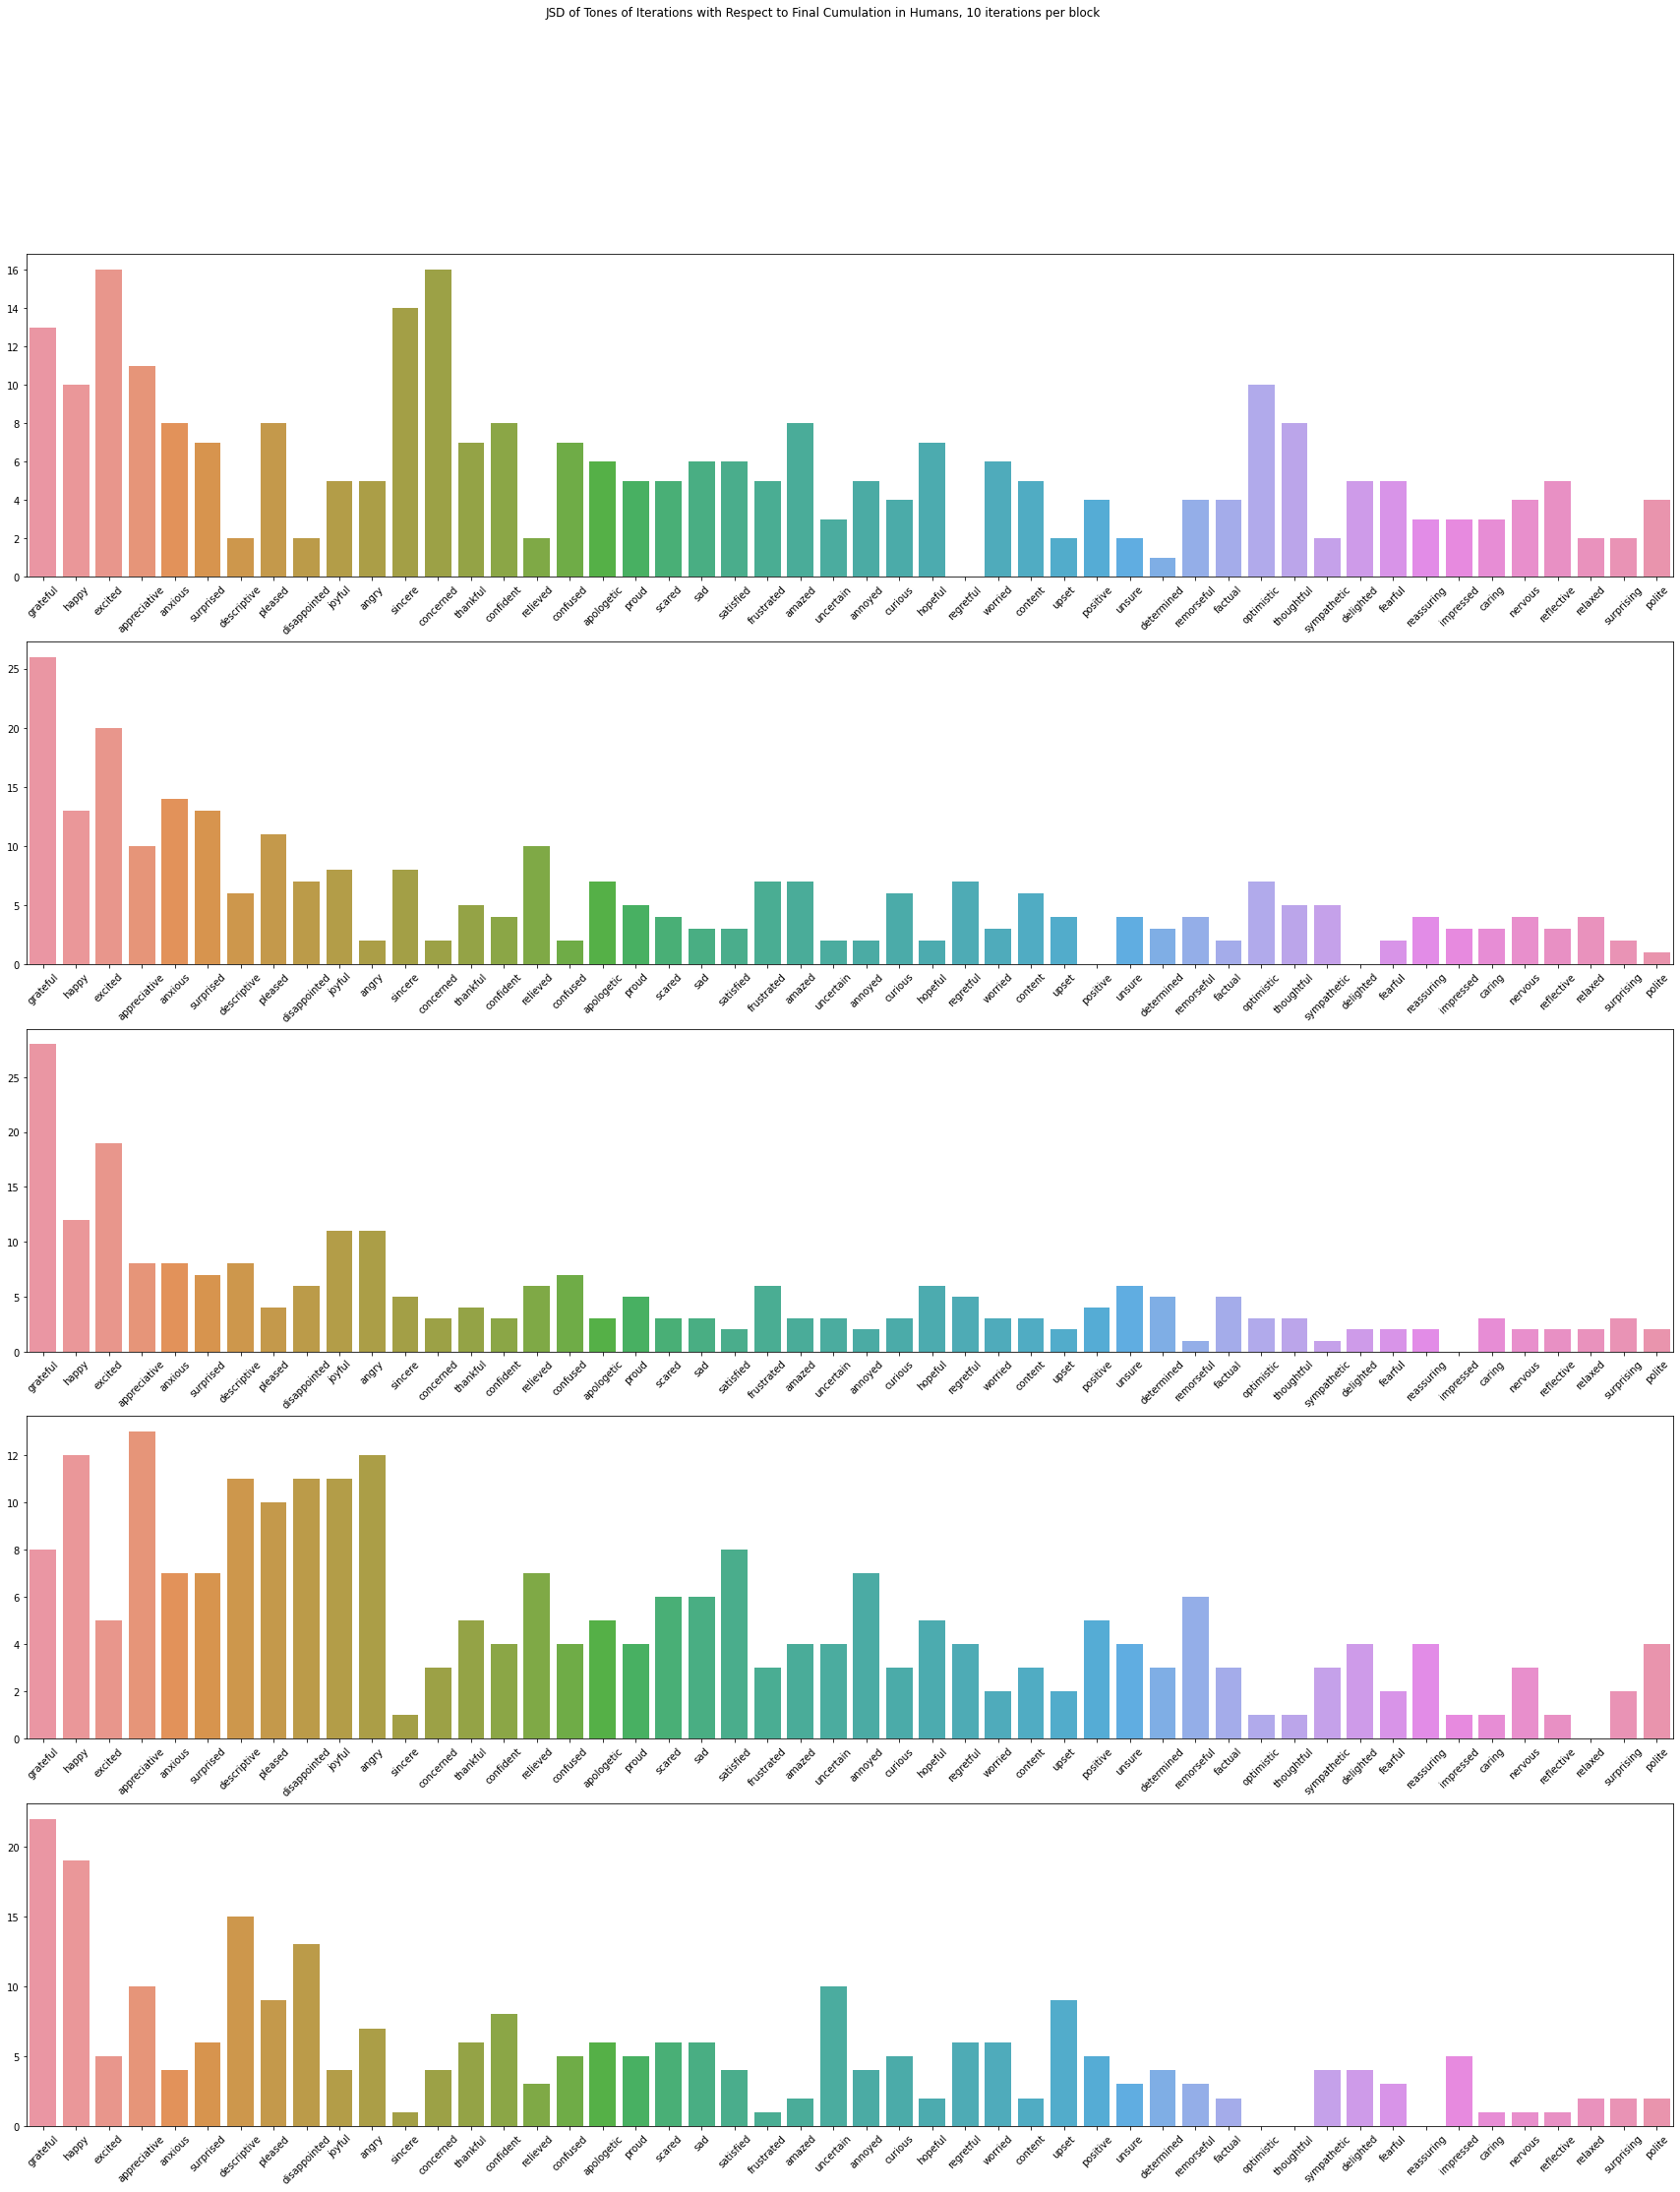

In [175]:
plot_hists(10, chain_trials_tones_coords_whole)

In [26]:
from scipy.spatial.distance import cosine, jensenshannon
from scipy.stats import entropy

In [188]:
def plot_distance(num_iter_per_block, df_table, cumulative=False, between_blocks=False, verbose=False):
    # if cumulative:
    #     tone_occurrence_table_whole_blocked = tone_occurrence_table_cumulative.T.groupby(np.arange(30)//num_iter_per_block).agg(lambda x: x.iloc[-1]).T
    # else:
    #     
    
    fig, ax = plt.subplots(figsize=(12, 12))
    tone_occurrence_table_whole_blocked = df_table.T.groupby(np.arange(50)//num_iter_per_block).sum().T
    if verbose:
        print(tone_occurrence_table_whole_blocked)
    if between_blocks:
        JSDs = [
            jensenshannon(
                tone_occurrence_table_whole_blocked.iloc[:, _it],
                tone_occurrence_table_whole_blocked.iloc[:, _it + 1] # [:, -1] #[:, _it + 1]
            )
            for _it in range(len(tone_occurrence_table_whole_blocked.columns) - 1)
        ]
        cosines = [
            cosine(
                tone_occurrence_table_whole_blocked.iloc[:, _it],
                tone_occurrence_table_whole_blocked.iloc[:, _it + 1] # [:, -1] #
            )
            for _it in range(len(tone_occurrence_table_whole_blocked.columns) - 1)
        ]
        plot_title = f"JSD of Tones of Iterations between Iteration Blocks in Humans, {num_iter_per_block} iterations per block"
    else:
        JSDs = [
            jensenshannon(
                tone_occurrence_table_whole_blocked.iloc[:, _it],
                tone_occurrence_table_whole_blocked.iloc[:, -1] #[:, _it + 1]
            )
            for _it in range(len(tone_occurrence_table_whole_blocked.columns) - 1)
        ]
        cosines = [
            cosine(
                tone_occurrence_table_whole_blocked.iloc[:, _it],
                tone_occurrence_table_whole_blocked.iloc[:, -1] #
            )
            for _it in range(len(tone_occurrence_table_whole_blocked.columns) - 1)
        ]
        plot_title = f"JSD of Tones of Iterations Blocks with Respect to Last in Humans, {num_iter_per_block} iterations per block"
    plt.plot(
        np.arange(len(tone_occurrence_table_whole_blocked.columns) - 1), JSDs, marker="o", label="JSD"
    )
    plt.plot(
        np.arange(len(tone_occurrence_table_whole_blocked.columns) - 1), cosines, marker="o", label="Cosine"
    )
    plt.ylim((0, 1))
    
    if cumulative:
        plot_title += ", cumulatively"
    plt.title(plot_title)
    plt.xlabel("Number of Block Iteration Cumulated")
    plt.ylabel("Distances")
    
    if cumulative:
        KLs = [
            entropy(
                tone_occurrence_table_whole_blocked.iloc[:, _it],
                tone_occurrence_table_whole_blocked.iloc[:, _it + 1]
            )
            for _it in range(len(tone_occurrence_table_whole_blocked.columns) - 1)
        ]
        plt.plot(
            np.arange(len(tone_occurrence_table_whole_blocked.columns) - 1), KLs, marker="x", label="KLD"
        )
    plt.legend()

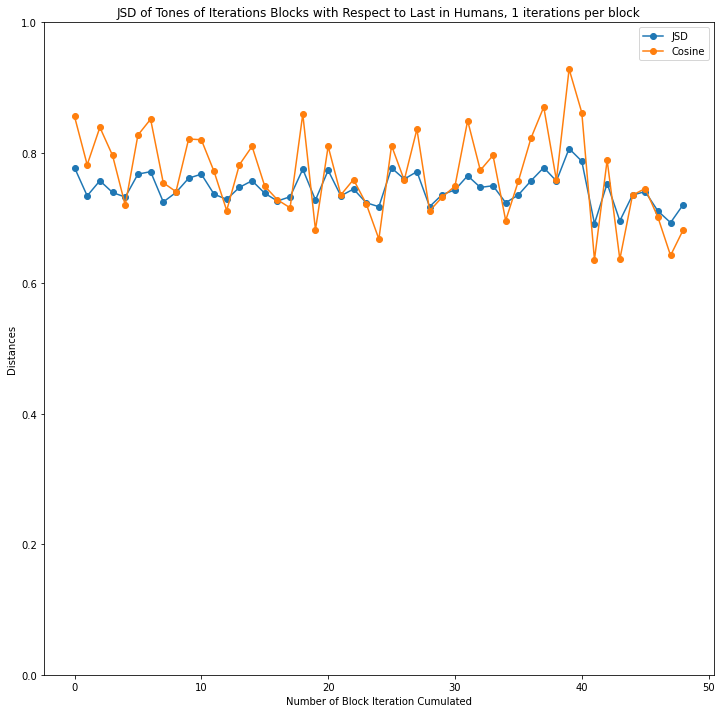

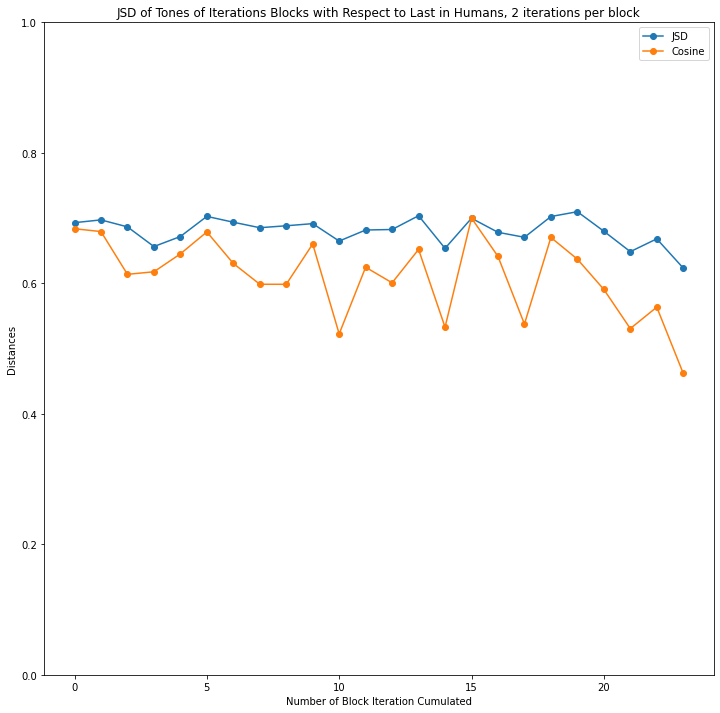

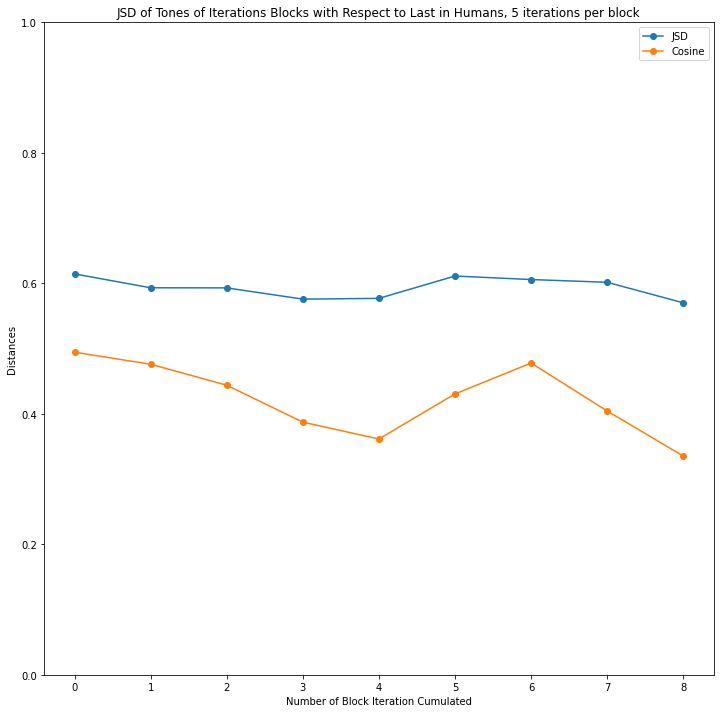

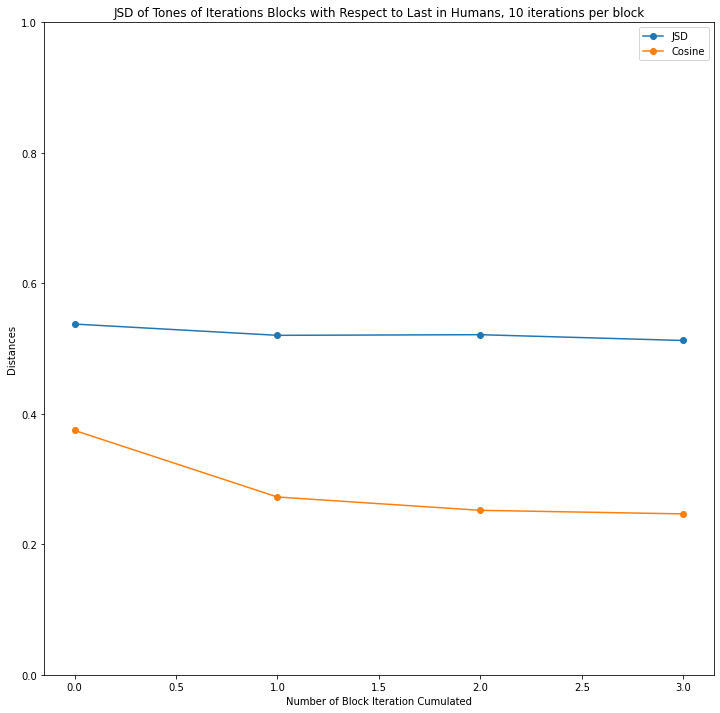

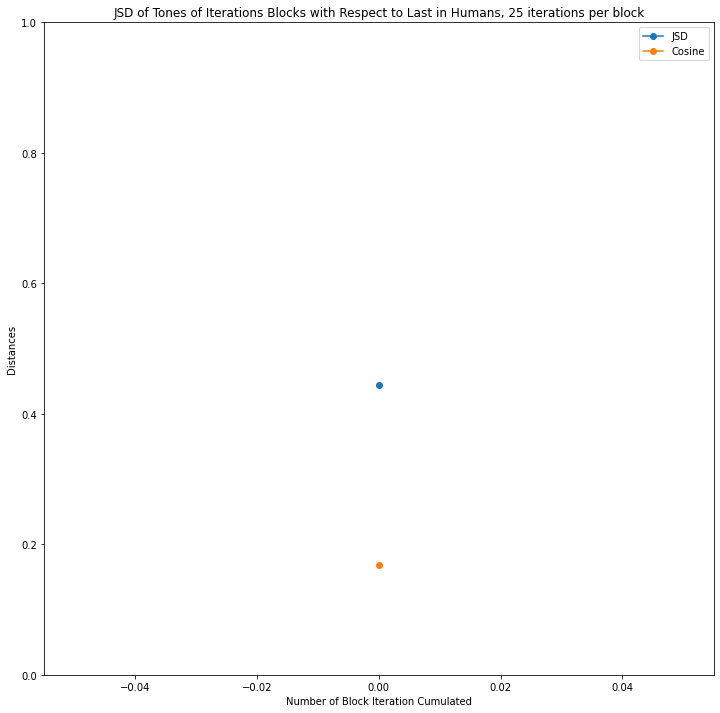

In [28]:
for _it in [1, 2, 5, 10, 25]:
    plot_distance(_it, tone_occurrence_table_whole, between_blocks=False)

In [29]:
tone_occurrence_table = pd.pivot_table(
    chain_trials_only_tones,
    index=["withholding_tone"],
    columns=["degree"],
    values="origin_id",
    aggfunc="count"
).fillna(0)
tone_occurrence_table_cumulative = tone_occurrence_table.cumsum(axis=1)
tone_occurrence_table_cumulative

degree,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
withholding_tone,,,,,,,,,,,,,,,,,,,,,
able,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
abrupt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
absorbed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
accepting,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
accommodating,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wondering,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
worried,2.0,2.0,2.0,2.0,4.0,4.0,7.0,7.0,7.0,7.0,...,14.0,15.0,15.0,16.0,17.0,17.0,19.0,19.0,20.0,20.0
worrying,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


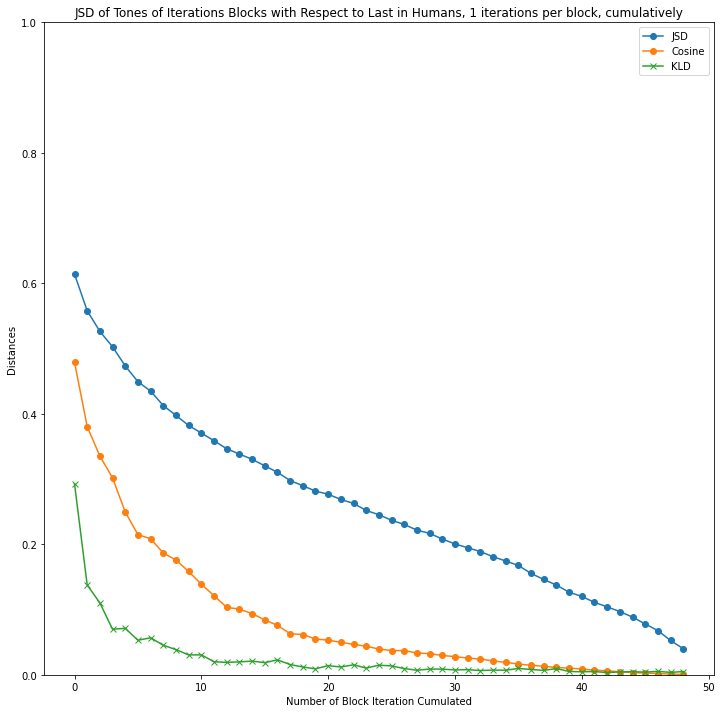

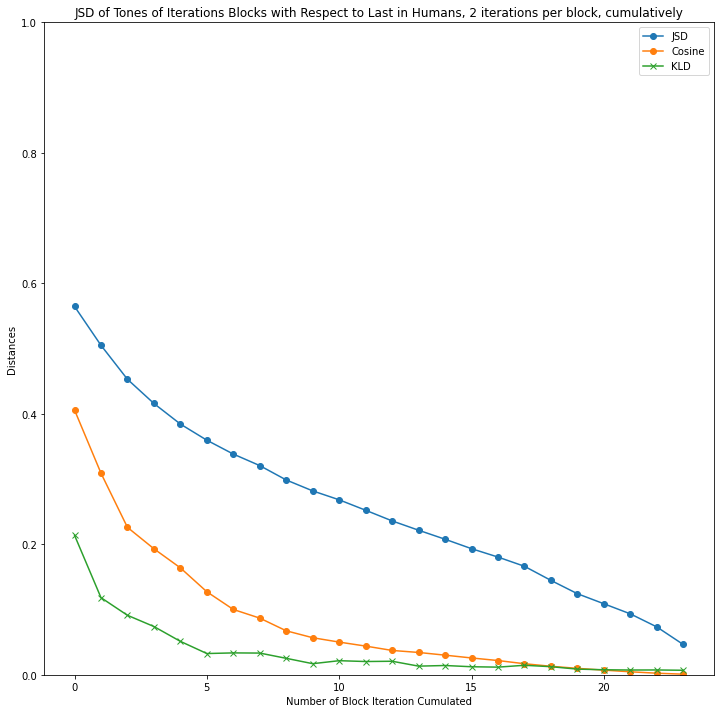

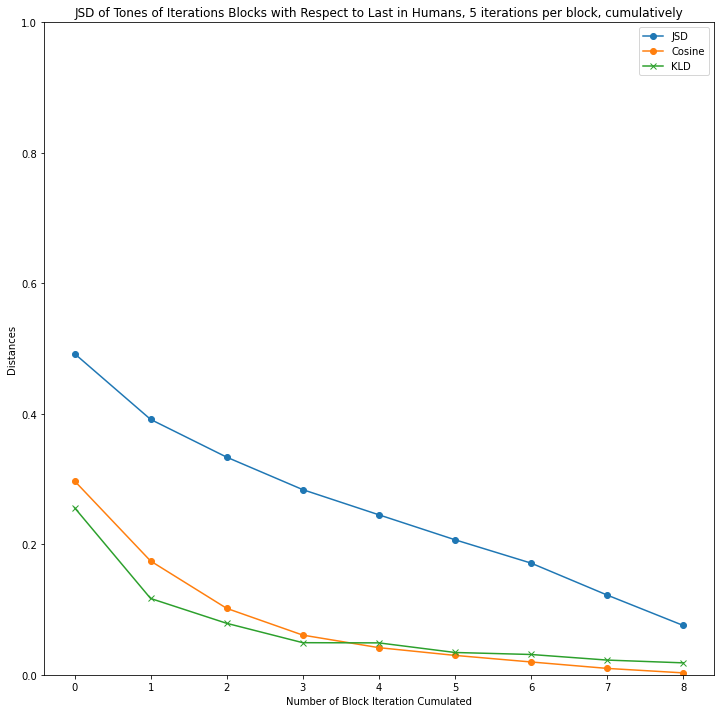

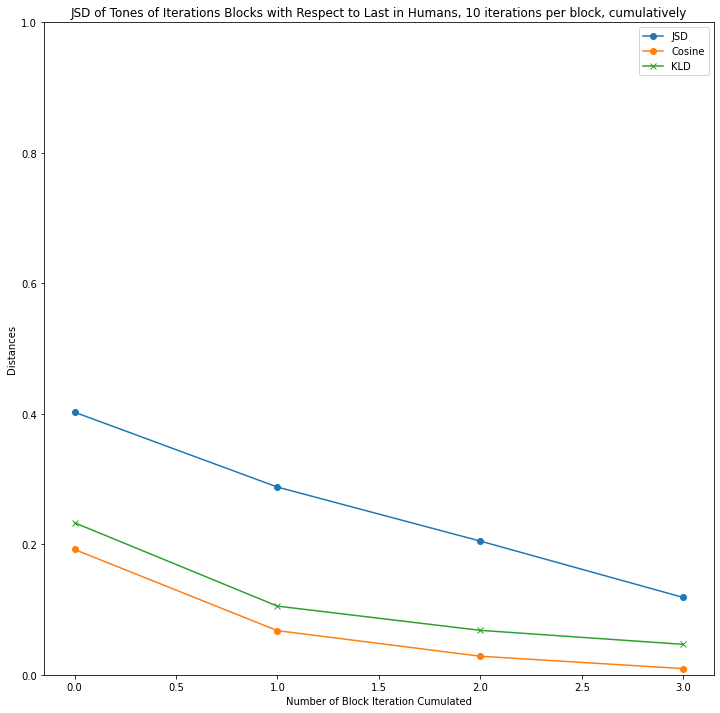

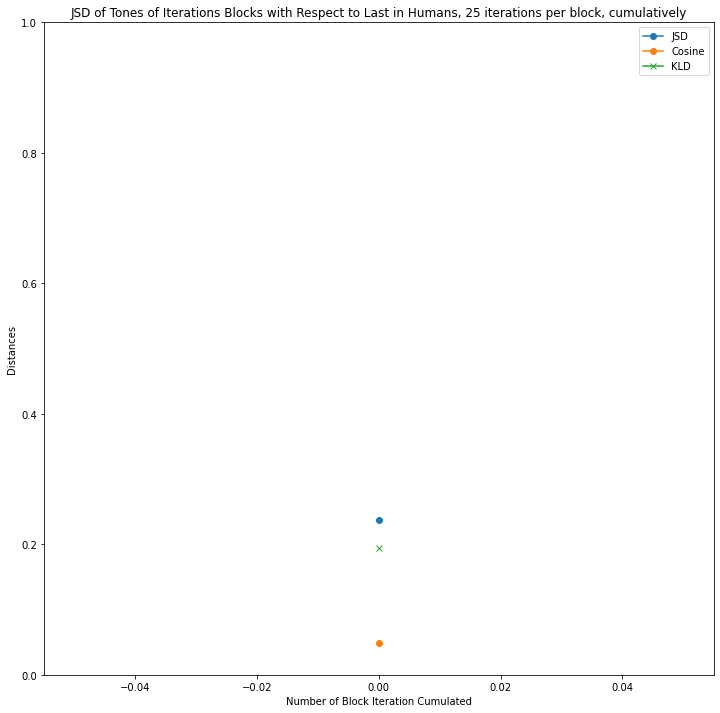

In [30]:
for _it in [1, 2, 5, 10, 25]:
    plot_distance(_it, tone_occurrence_table_cumulative, cumulative=True)

### Taxonomy

In [31]:
chain_tone_embeddings = pd.DataFrame(obtained_embeddings).T
chain_tone_embeddings_np = chain_tone_embeddings.to_numpy()
chain_tone_embeddings

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
able,-0.030342,0.054782,0.023634,-0.063776,-0.092995,-0.031521,0.036947,-0.122220,0.029599,-0.030286,...,0.009729,0.007849,-0.019687,-0.029005,0.022186,0.005311,-0.037654,-0.014363,-0.012932,-0.033465
abrupt,-0.064711,0.016115,0.040810,0.108070,0.004493,0.102090,-0.079958,-0.135490,-0.051100,0.074035,...,-0.043487,0.020873,0.038502,-0.051297,-0.043737,0.049903,0.040175,0.103800,0.023928,0.046676
absorbed,0.000020,0.016180,0.048122,-0.014402,0.093310,0.032961,0.001985,-0.077697,0.038922,-0.032412,...,0.030735,0.057012,-0.013853,-0.060518,0.012341,-0.011770,0.073377,0.019187,0.051980,-0.003948
accepting,0.031378,0.024422,0.009744,-0.035777,-0.047032,-0.003002,0.007776,-0.100710,-0.032615,0.020277,...,0.028616,0.016572,0.091524,-0.016860,-0.017885,0.009897,0.048495,0.005141,-0.004332,-0.010661
accommodating,0.012513,-0.003378,0.000902,-0.021804,-0.028189,0.028478,-0.010649,-0.074675,-0.055754,0.022449,...,-0.015251,0.016941,0.025047,-0.050521,-0.009765,-0.003258,0.007098,0.048445,0.016971,-0.001961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wondering,-0.064270,0.009523,0.009980,0.001789,-0.024903,0.013461,-0.019256,-0.074610,-0.057880,0.003036,...,0.032826,-0.026403,-0.056978,0.014674,0.017340,-0.035211,-0.013074,-0.001266,0.045068,0.021511
worried,-0.029563,-0.040746,-0.033914,-0.038670,-0.021008,0.077145,-0.025697,-0.095594,-0.004467,0.043464,...,-0.028359,-0.022475,-0.008241,0.000337,-0.039262,-0.043411,-0.050736,0.050127,0.013275,0.026673
worrying,-0.016457,-0.058425,-0.067307,-0.068023,-0.011293,0.063566,-0.025731,-0.110120,-0.048834,0.007507,...,0.015224,-0.035282,0.027800,-0.030464,-0.035432,-0.020032,-0.035889,0.036256,0.014816,0.013995
wrathful,-0.009655,-0.027440,0.069590,-0.015063,-0.034544,-0.069966,-0.022110,-0.102450,-0.008313,0.074751,...,0.007495,-0.015039,0.005624,-0.017313,-0.017076,0.020759,0.038952,0.098849,-0.016700,0.038535


In [32]:
from scipy.spatial.distance import cdist

In [33]:
def get_corpus_similarity_matrix_PCAs(table_np, metric="cosine"):
    sim_matrix = cdist(table_np, table_np, metric=metric)
    sim_matrix_map = {}
    U, S, Vt = np.linalg.svd(1 - sim_matrix)
    for i in range(np.linalg.matrix_rank(sim_matrix)):
        sim_matrix_map[i + 1] = U[:, :i + 1] @ np.diag(S[:i + 1]) @ Vt[:i + 1, :]
    return sim_matrix_map

def find_validity(tone_order, sim_PCA_order_map):
    for resolution, sim_approx in reversed(sim_PCA_order_map.items()):
        if sim_approx[tone_order, tone_order] < max(sim_approx[tone_order]):
            return resolution + 1
    return 1

cosine_map = get_corpus_similarity_matrix_PCAs(chain_tone_embeddings_np)
full_cosine_matrix = list(cosine_map.values())[-1]
validity_ranks = {
    i: (chain_tone_embeddings.index[i], find_validity(i, cosine_map))
    for i in range(len(chain_tone_embeddings.index))
}
validity_ranks_df = pd.DataFrame(validity_ranks).T.rename(
    columns = {
        0: "tone",
        1: "validity_rank"
    }
)
validity_ranks_df

,tone,validity_rank
0,able,7
1,abrupt,17
2,absorbed,35
3,accepting,15
4,accommodating,17
...,...,...
581,wondering,9
582,worried,8
583,worrying,8
584,wrathful,35


In [34]:
def get_coverage(higher_rank_tone, lower_rank_tone, sim_PCA_order_map, validity_ranks):
    higher_rank = validity_ranks[higher_rank_tone][1]
    lower_rank = validity_ranks[lower_rank_tone][1]
    k_min, k_max = float("inf"), -float("inf")
    for k in range(lower_rank, higher_rank):
        current_resolution_sim = sim_PCA_order_map[k]
        if current_resolution_sim[higher_rank_tone][lower_rank_tone] >= current_resolution_sim[higher_rank_tone][higher_rank_tone]:
            k_min = min(k_min, k)
            k_max = max(k_max, k)
    rank_diff = max(1, higher_rank - lower_rank)
    if k_min == float("inf"):
        return 0
    return (k_max - k_min + 1) / rank_diff

def get_coverage_matrix(sim_PCA_order_map, validity_ranks):
    coverage_matrix = np.ones(shape=(len(validity_ranks), len(validity_ranks))) * -1
    for i in range(len(validity_ranks)):
        for j in range(i + 1):
            higher_rank_tone = max([i, j], key=lambda x: validity_ranks[x])
            lower_rank_tone = min([j, i], key=lambda x: validity_ranks[x])
            coverage = get_coverage(higher_rank_tone, lower_rank_tone, sim_PCA_order_map, validity_ranks)
            coverage_matrix[i][j] = coverage
            coverage_matrix[j][i] = coverage
    return coverage_matrix

In [35]:
def taxonomization(
        coverage_matrix,
        validity_ranks,
        tiebreaker_matrix,
        terminate_threshold=0,
        coverage_revision=lambda a, b, c, d: a
    ):
    indices_to_search = np.arange(coverage_matrix.shape[0])
    cluster_log = {}
    cluster_event_id = 1
    while len(indices_to_search) >= 1:
        max_coverage_ind = coverage_matrix[indices_to_search][:, indices_to_search].argmax()
        max_coverage_inds = (
            indices_to_search[max_coverage_ind // len(indices_to_search)],
            indices_to_search[max_coverage_ind % len(indices_to_search)]
        )
        max_coverage = coverage_matrix[max_coverage_inds[0], max_coverage_inds[1]]
        representative = max(max_coverage_inds, key=lambda x: validity_ranks[x])
        merged = max_coverage_inds[1] if representative == max_coverage_inds[0] else max_coverage_inds[0]
        # assert representative != merged, "Encountered self-merging clusters."
        revised_coverage_metric = coverage_revision(max_coverage, representative, merged, tiebreaker_matrix)
        if revised_coverage_metric <= terminate_threshold:
            cluster_log[cluster_event_id] = {
                "coverage": max_coverage
            }
            break
        cluster_stage = "cosine" if revised_coverage_metric < 1 else "coverage"
        cluster_log[cluster_event_id] = {
            "representative": representative,
            "merged": merged,
            "repr_rank": validity_ranks[representative],
            "merg_rank": validity_ranks[merged],
            "coverage": revised_coverage_metric,
            "stage": cluster_stage
        }
        indices_to_search = np.delete(indices_to_search, np.where(indices_to_search == merged))
        cluster_event_id += 1
    return cluster_log

def coverage_and_cosine(coverage, repre, merg, tiebreaker_matrix):
    repr_merg_cosine = tiebreaker_matrix[repre, merg]
    if repre == merg:
        repr_merg_cosine = 0
    return coverage * 10 + repr_merg_cosine

In [36]:
coverage_matrix = get_coverage_matrix(cosine_map, validity_ranks)
full_cosine_matrix_parsed = np.where(np.isclose(full_cosine_matrix, 1), 0, full_cosine_matrix)
taxonomization_results = taxonomization(
    10 * coverage_matrix + full_cosine_matrix_parsed,
    [v[1] for v in validity_ranks.values()],
    full_cosine_matrix,
    #coverage_revision=coverage_and_cosine
)

In [149]:
tone_names = pd.DataFrame(chain_tone_embeddings.index).reset_index().rename(columns={"index":"tone_id", 0:"tone"})
taxonomization_df = pd.DataFrame(taxonomization_results).T
taxonomization_df = taxonomization_df.reset_index().rename(columns={"index":"cluster_event_id"})
taxonomization_df = taxonomization_df.merge(tone_names, left_on="representative", right_on="tone_id").rename(columns={"tone": "representative_name"})
taxonomization_df = taxonomization_df.merge(tone_names, left_on="merged", right_on="tone_id").rename(columns={"tone": "merged_name"})
taxonomization_df = taxonomization_df.drop(["tone_id_x", "tone_id_y"], axis = 1)
taxonomization_df_coverages = taxonomization_df.sort_values("cluster_event_id")#.query("stage=='coverage'")
taxonomization_df_coverages

,cluster_event_id,representative,merged,repr_rank,merg_rank,coverage,stage,representative_name,merged_name
0,1,199,198,44,12,10.895249,coverage,empathic,empathetic
16,2,52,23,17,6,10.883591,coverage,astounded,amazed
17,3,517,262,22,10,10.870794,coverage,thankful,grateful
23,4,91,90,17,4,10.870532,coverage,cheery,cheerful
25,5,468,241,17,12,10.864162,coverage,scared,frightened
...,...,...,...,...,...,...,...,...,...
12,581,199,99,44,20,0.355402,cosine,empathic,commanding
72,582,257,414,36,35,0.289354,cosine,gobsmacked,pregnant
13,583,199,335,44,40,0.287689,cosine,empathic,largest
14,584,199,170,44,23,0.28737,cosine,empathic,discontent


In [69]:
import graphviz

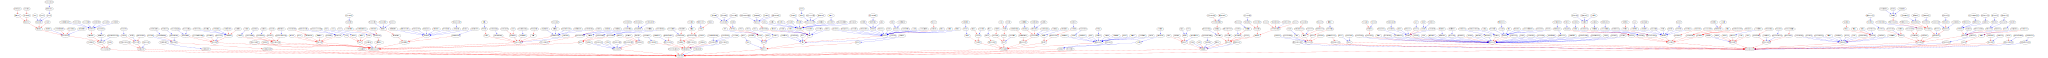

In [150]:
gpt_taxonomization_graph = graphviz.Digraph(
    filename=f"./export-data/tax.pdf",
    #graph_attr={'rankdir':'LR'}
)
tax_tone_names = list(tone_names["tone"])
for tone_id, tone_name in enumerate(tax_tone_names):
    gpt_taxonomization_graph.node(str(tone_id), tone_name, shape="oval")
edge_color_map = {
    "coverage": "blue",
    "cosine": "red"
}
for cluster_event in taxonomization_results.values():
    if cluster_event["coverage"] == 0:
        break
    gpt_taxonomization_graph.edge(
        str(cluster_event["merged"]),
        str(cluster_event["representative"]),
        color=edge_color_map[cluster_event["stage"]]
    )
gpt_taxonomization_graph

In [203]:
tone_to_cluster_map = {i: -i for i in range(len(obtained_embeddings))}
cluster_to_tone_map = {}
termination = 560  # taxonomization_df_coverages.shape[0] + 1
for event_id in range(1, termination):
    current_cluster = taxonomization_df_coverages.query(f"cluster_event_id=={event_id}")
    cluster_to_tone_map[event_id] = set()
    joining_tone_ids = [current_cluster["representative"].item(), current_cluster["merged"].item()]
    for current_tone_id in joining_tone_ids:
        cluster_to_tone_map[event_id].add(current_tone_id)
        contained_cluster = tone_to_cluster_map[current_tone_id]
        
        if contained_cluster > 0:
            for to_join_tones in cluster_to_tone_map[contained_cluster]:
                cluster_to_tone_map[event_id].add(to_join_tones)
                tone_to_cluster_map[to_join_tones] = event_id
            # del cluster_to_tone_map[contained_cluster]
        tone_to_cluster_map[current_tone_id] = event_id

In [204]:
tone_cluster_df = pd.DataFrame(
    data = {
        "tone_id": tone_to_cluster_map.keys(),
        "cluster": tone_to_cluster_map.values()
    }
).merge(tone_names, on="tone_id")
len(tone_cluster_df["cluster"].unique())

27

In [205]:
chain_trials_tones_coords_clust_whole = chain_trials_tones_coords_whole.merge(tone_cluster_df, left_on="withholding_tone", right_on="tone")
chain_trials_tones_coords_clust_whole

,origin_id,network_id,node_mode,withholding_tone,time_taken,degree,MDS_x,MDS_y,tone_id,cluster,tone
0,3,3,c,kind,13.456,0,-0.184442,-0.757951,330,550,kind
1,1525,38,c,kind,16.214,12,-0.184442,-0.757951,330,550,kind
2,1074,49,c,kind,20.187,7,-0.184442,-0.757951,330,550,kind
3,4405,91,c,kind,18.840,33,-0.184442,-0.757951,330,550,kind
4,1016,3,c,thoughtful,127.640,10,-0.040997,-0.298397,519,553,thoughtful
...,...,...,...,...,...,...,...,...,...,...,...
2244,1997,92,c,greedy,4.995,29,0.998538,0.068758,266,540,greedy
2245,1906,92,c,greedy,3.952,27,0.998538,0.068758,266,540,greedy
2246,2241,92,c,greedy,15.491,33,0.998538,0.068758,266,540,greedy
2247,1836,92,c,selfish,46.032,25,-0.716708,-0.036952,471,537,selfish


In [206]:
cluster_occurrence_table_whole = pd.pivot_table(
    chain_trials_tones_coords_clust_whole,
    index=["cluster"],
    columns=["degree"],
    values="origin_id",
    aggfunc="count"
).fillna(0)
cluster_occurrence_table_whole

degree,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
cluster,,,,,,,,,,,,,,,,,,,,,
-99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,0.0,0.0,1.0,0.0,0.0,2.0,1.0,1.0,2.0,2.0,...,2.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,0.0,1.0
489,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
512,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
518,1.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0


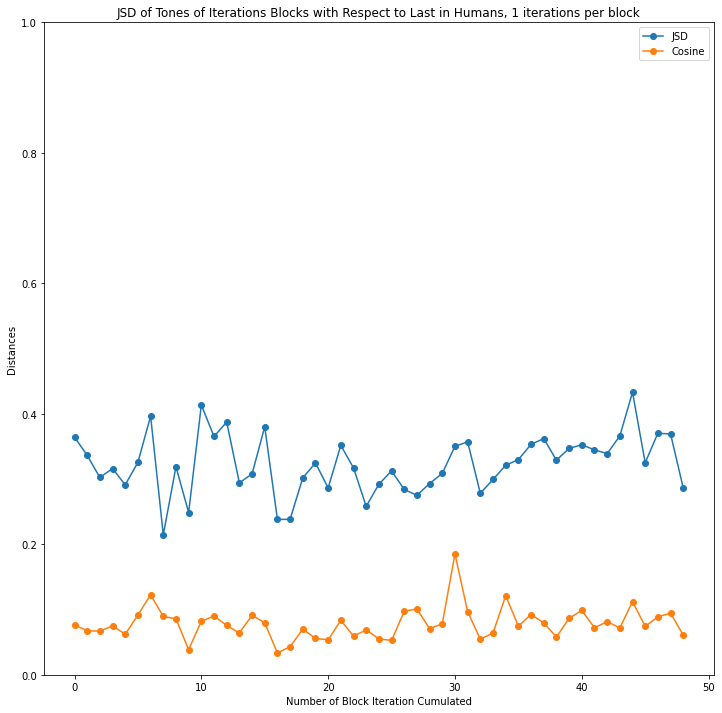

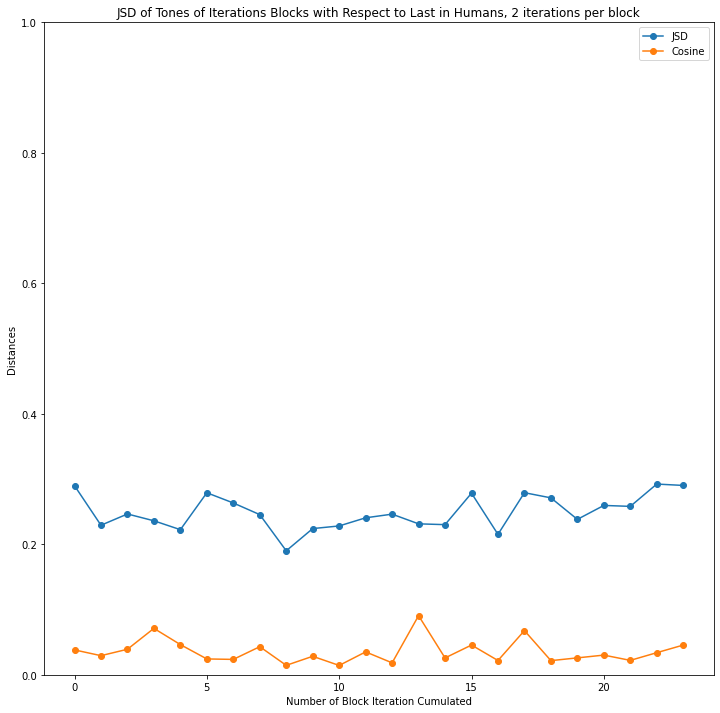

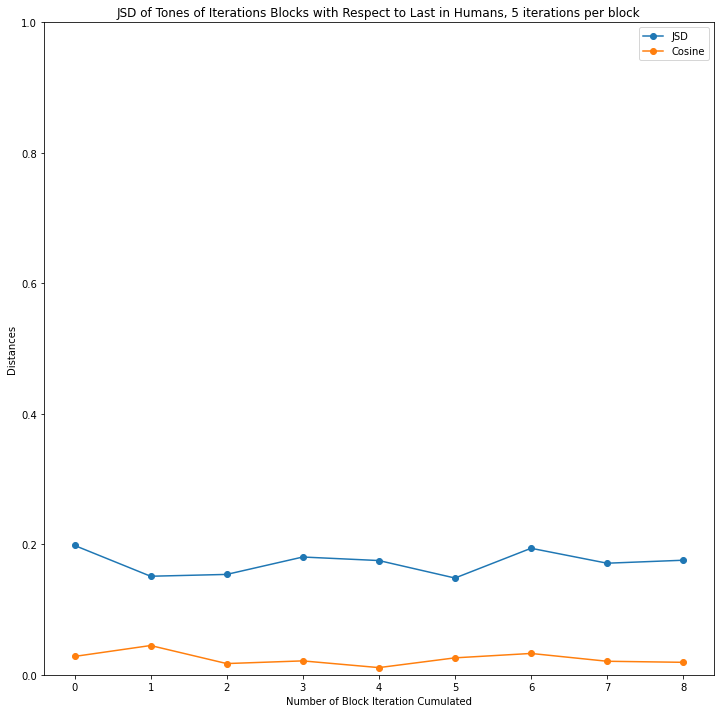

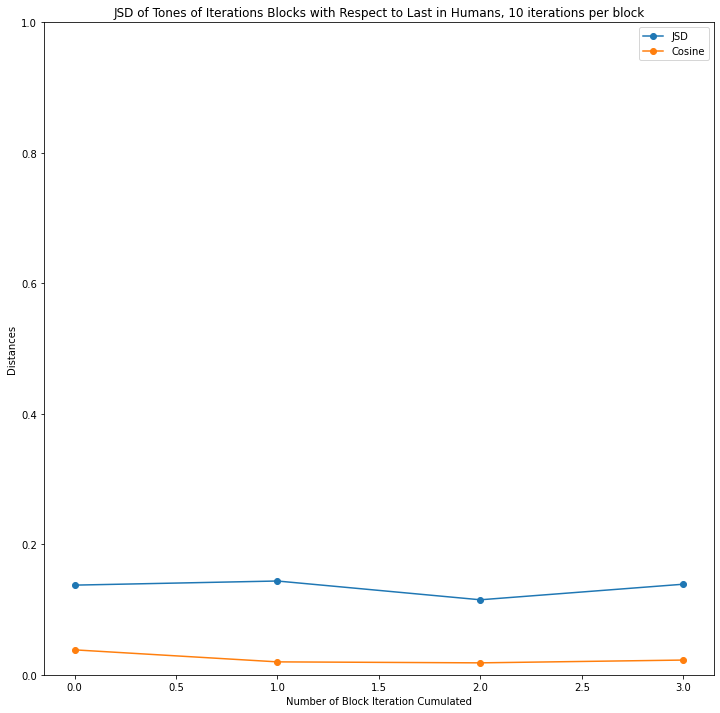

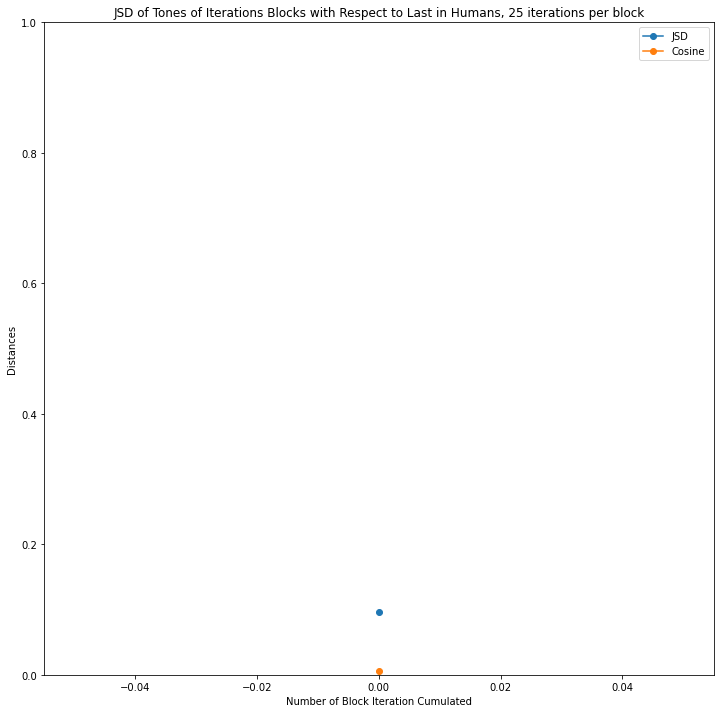

In [207]:
for _it in [1, 2, 5, 10, 25]:
    plot_distance(_it, cluster_occurrence_table_whole, between_blocks=False)

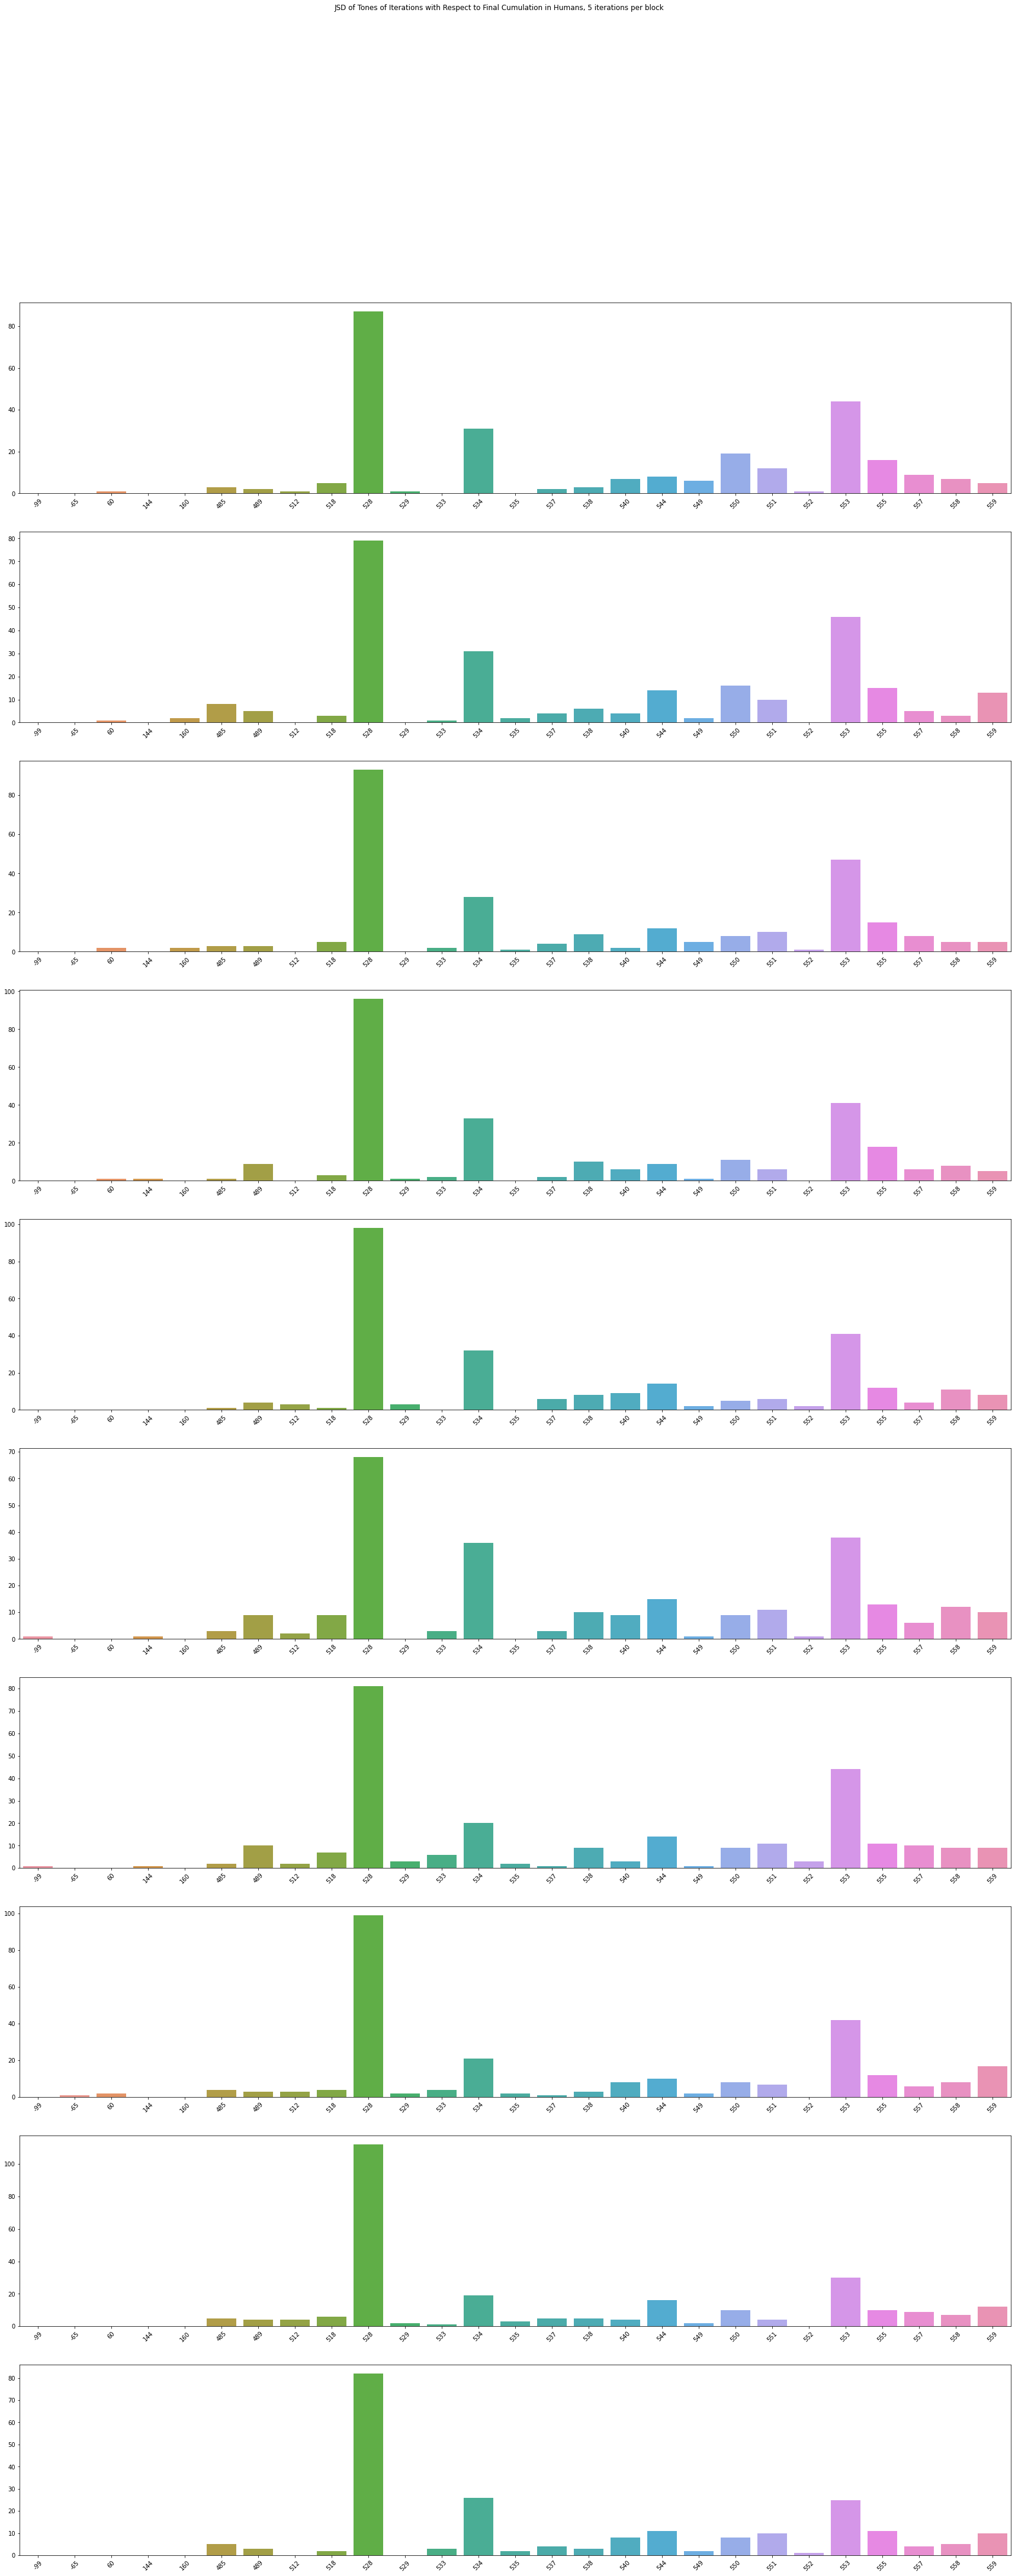

In [212]:
plot_hists(5, chain_trials_tones_coords_clust_whole, "cluster")

### other things

In [26]:
from scipy.stats import entropy

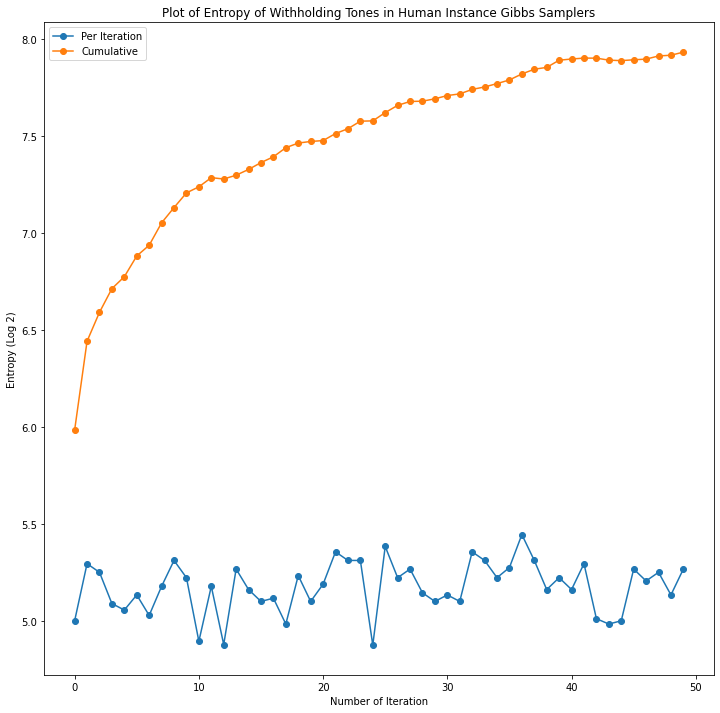

In [27]:
entropies_per_iter = [
    entropy(
        tone_occurrence_table_whole.iloc[:, _it]/sum(tone_occurrence_table_whole.iloc[:, _it]),
        base=2
    )
    for _it in range(50)
]
entropies_per_iter_cumulative = [
    entropy(
        tone_occurrence_table_cumulative.iloc[:, _it]/sum(tone_occurrence_table_cumulative.iloc[:, _it]),
        base=2
    )
    for _it in range(50)
]
fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(
    np.arange(50), entropies_per_iter, label="Per Iteration", marker="o"
)
plt.plot(
    np.arange(50), entropies_per_iter_cumulative, label="Cumulative", marker="o"
)
plt.title("Plot of Entropy of Withholding Tones in Human Instance Gibbs Samplers")
plt.xlabel("Number of Iteration")
plt.ylabel("Entropy (Log 2)")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (29,) and (49,)

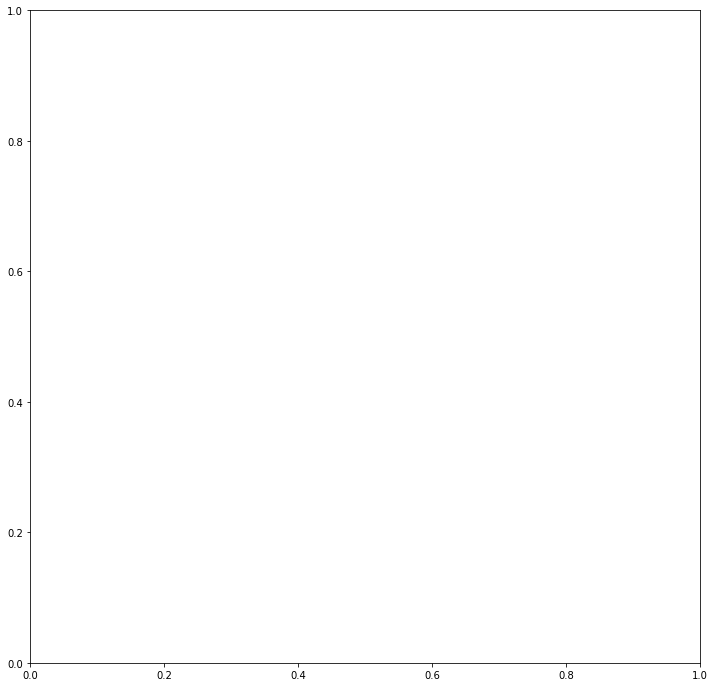

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(
    np.arange(1, 30), np.diff(entropies_per_iter_cumulative), label="Cumulative", marker="o"
)
plt.title("Plot of Marginal Entropy of Withholding Tones in Human Instance")
plt.xlabel("Number of Iteration")
plt.ylabel("Entropy (Log 2)")

In [ ]:
from scipy.spatial.distance import cosine

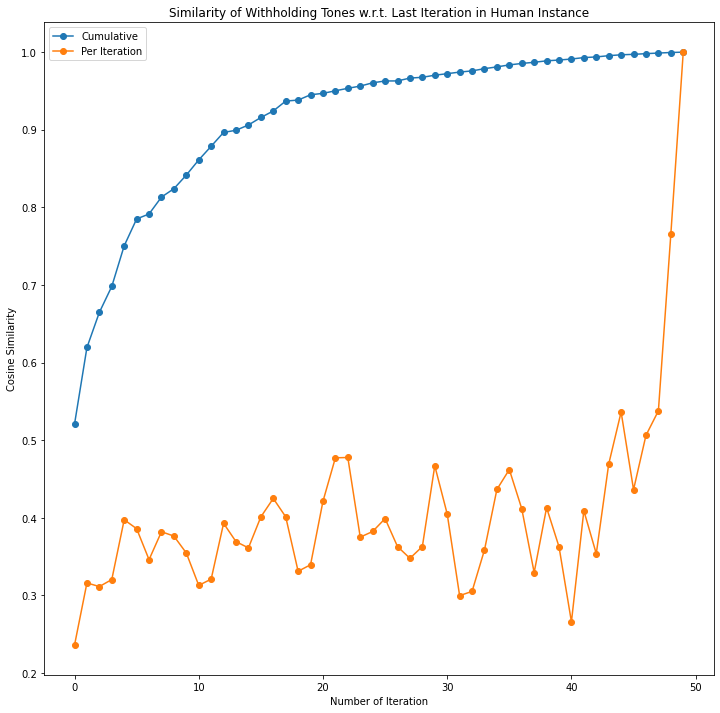

In [ ]:
similarity_over_iterations_cum = [
    1 - cosine(
        tone_occurrence_table_cumulative.iloc[:, _it].values,
        tone_occurrence_table_cumulative.iloc[:, -1].values
    )
    for _it in range(50)
]
similarity_over_iterations_per_iter = [
    1 - cosine(
        tone_occurrence_table_whole.iloc[:, _it].values,
        tone_occurrence_table_whole.iloc[:, -1].values
    )
    for _it in range(50)
]

fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(
    np.arange(50), similarity_over_iterations_cum, label="Cumulative", marker="o"
)
plt.plot(
    np.arange(50), similarity_over_iterations_per_iter, label="Per Iteration", marker="o"
)
plt.title("Similarity of Withholding Tones w.r.t. Last Iteration in Human Instance")
plt.xlabel("Number of Iteration")
plt.ylabel("Cosine Similarity")
plt.legend()

Text(0, 0.5, 'Relative Entropy')

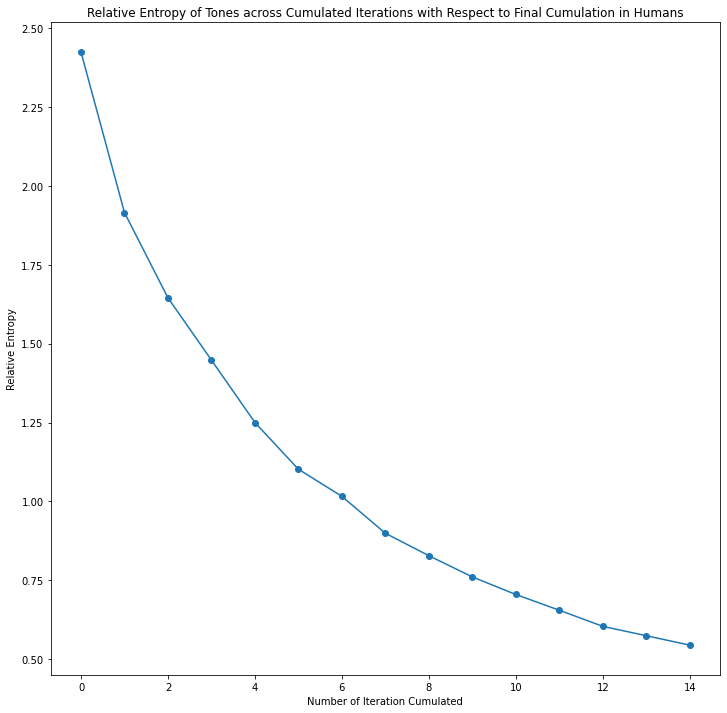

In [ ]:
relative_entropies_per_iter_cumulative = [
    entropy(
        tone_occurrence_table_cumulative.iloc[:, _it]/sum(tone_occurrence_table_cumulative.iloc[:, _it]),
        tone_occurrence_table_cumulative.iloc[:, -1]/sum(tone_occurrence_table_cumulative.iloc[:, -1]),
        base=2
    )
    for _it in range(15)
]
fig, ax = plt.subplots(figsize=(12, 12))
plt.plot(
    np.arange(15), relative_entropies_per_iter_cumulative, marker="o", label="Cumulative"
)
plt.title("Relative Entropy of Tones across Cumulated Iterations with Respect to Final Cumulation in Humans")
plt.xlabel("Number of Iteration Cumulated")
plt.ylabel("Relative Entropy")

In [ ]:
from scipy.spatial.distance import jensenshannon

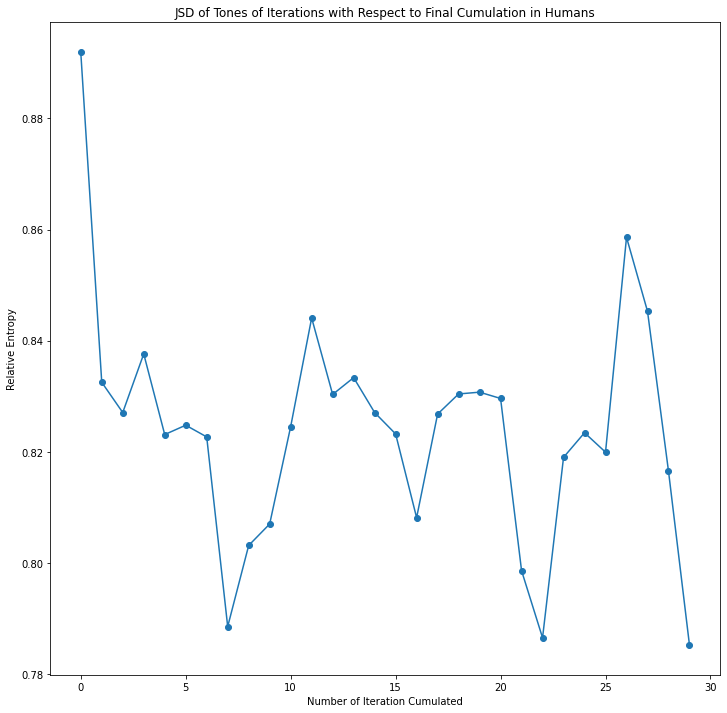

In [ ]:
relative_entropies_per_iter_cumulative = [
    jensenshannon(
        tone_occurrence_table_whole.iloc[:, _it]/sum(tone_occurrence_table_whole.iloc[:, _it]),
        tone_occurrence_table_whole.iloc[:, -1]/sum(tone_occurrence_table_whole.iloc[:, -1]),
        base=2
    )
    for _it in range(30)
]
fig, ax = plt.subplots(figsize=(12, 12))
plt.title("JSD of Tones of Iterations with Respect to Final Cumulation in Humans")
plt.xlabel("Number of Iteration Cumulated")
plt.ylabel("Relative Entropy")
plt.plot(
    np.arange(30), relative_entropies_per_iter_cumulative, marker="o", label="Per-Iteration"
)

Text(0.5, 1.0, 'Histogram of Time Taken per Prompt in SRE Instances')

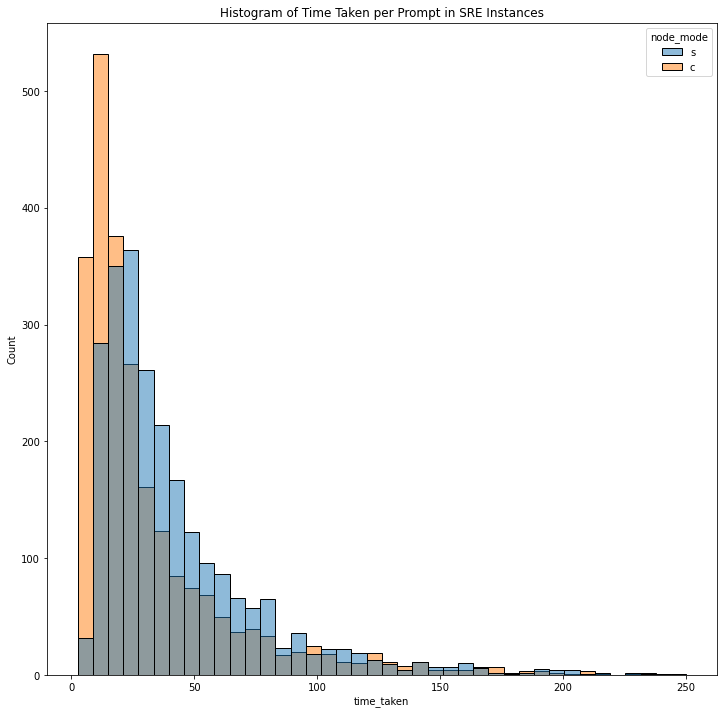

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.histplot(
    data = trial_df_compact,
    x = "time_taken",
    hue = "node_mode",
    alpha=0.5,
    bins=40
)
plt.title("Histogram of Time Taken per Prompt in SRE Instances")